### PROYECTO: PREDICCIÓN DE LA TASA DE DESEMPLEO EN COLOMBIA: UN ESTUDIO COMPARATIVO DE MODELOS HÍBRIDOS Y AVANZADOS.

### MODELO LSTM - GRU

#### Elaborado por: Yairo Oviedo

Trial 10 Complete [00h 00m 54s]
val_loss: 0.0007984990952536464

Best val_loss So Far: 0.0007984990952536464
Total elapsed time: 00h 05m 17s
Epoch 1/200
3/3 [==============================] - 4s 509ms/step - loss: 0.0166 - val_loss: 0.0086
Epoch 2/200
3/3 [==============================] - 1s 207ms/step - loss: 0.0156 - val_loss: 0.0074
Epoch 3/200
3/3 [==============================] - 1s 208ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 4/200
3/3 [==============================] - 1s 200ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 5/200
3/3 [==============================] - 1s 208ms/step - loss: 0.0131 - val_loss: 0.0085
Epoch 6/200
3/3 [==============================] - 1s 191ms/step - loss: 0.0127 - val_loss: 0.0075
Epoch 7/200
3/3 [==============================] - 1s 193ms/step - loss: 0.0132 - val_loss: 0.0076
Epoch 8/200
3/3 [==============================] - 1s 191ms/step - loss: 0.0119 - val_loss: 0.0088
Epoch 9/200
3/3 [==============================] - 1s 191ms/step - 

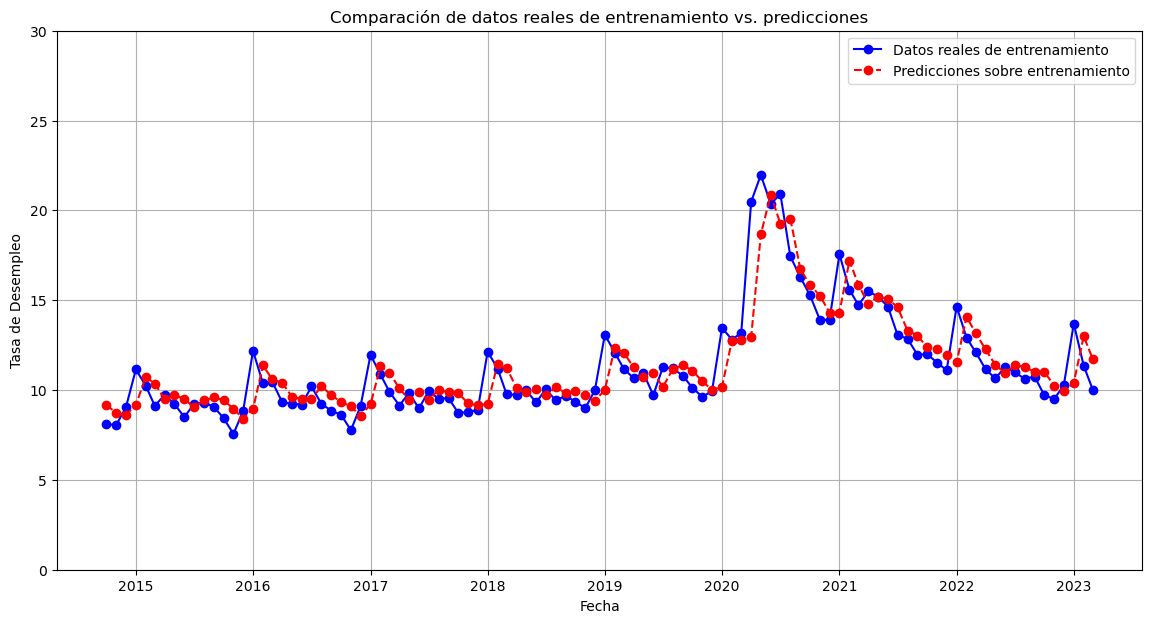

Combined Model (Train) - RMSE: 1.4476065455711742
Combined Model (Train) - MAE: 1.0069000210481533
Combined Model (Train) - MAPE: 8.547102603783138
Combined Model (Train) - R^2: 0.7480781329012149
1/1 [==============================] - 0s 50ms/step
LSTM-GRU Model (Test) - RMSE: 1.0943796666234642
LSTM-GRU Model (Test) - MAE: 0.793273070199149
LSTM-GRU Model (Test) - MAPE: 7.215563154658186
LSTM-GRU Model (Test) - R^2: 0.31693329591776354


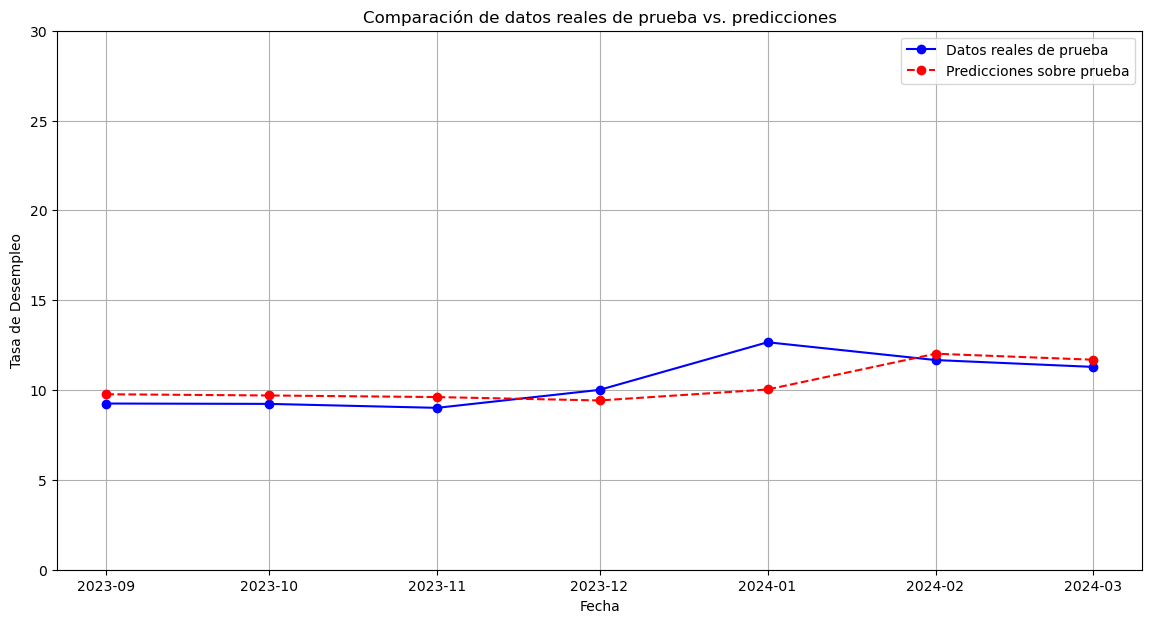

1/1 [==============================] - 0s 34ms/step


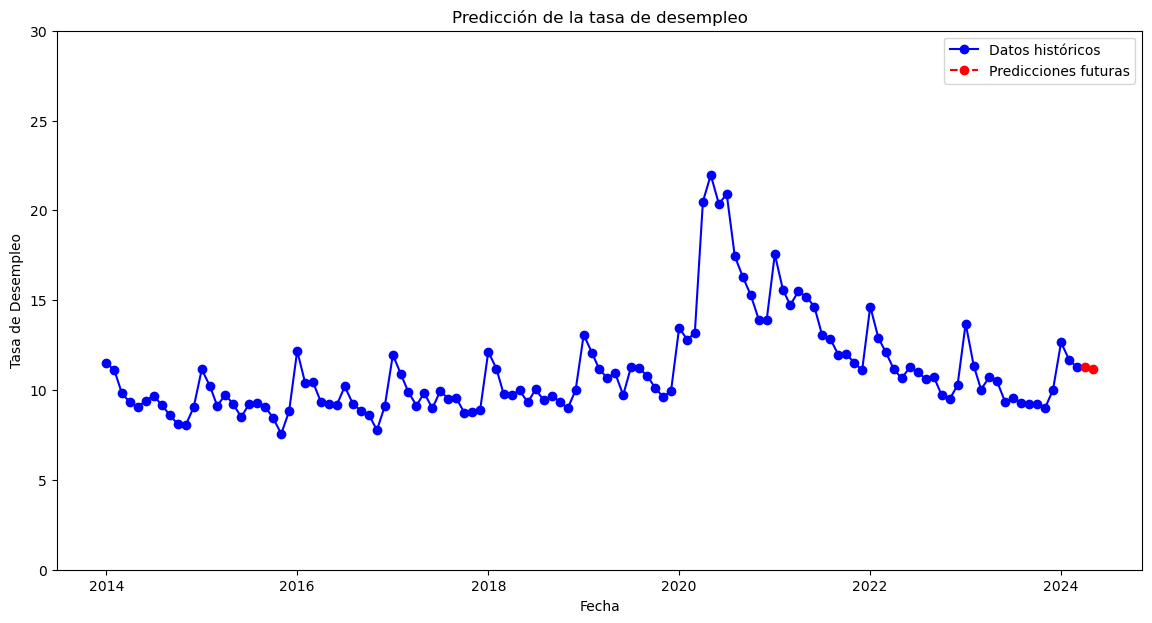

In [4]:
# Cargue de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras_tuner as kt
import shutil

# Limpiar el directorio de Keras Tuner
shutil.rmtree('keras_tuner_dir', ignore_errors=True)

# Configuración inicial
np.random.seed(0)
tf.random.set_seed(0)

# Carga de datos
file_path = 'TD_BUSQUEDAS_GOOGLE.csv'
df_cleaned = pd.read_csv(file_path, sep=";", parse_dates=['Mes'], index_col='Mes')
df_cleaned = df_cleaned.loc['2014-01-01':'2024-04-30']
df_cleaned = df_cleaned.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', '.'), errors='coerce')).dropna()

# Extraer la serie temporal de la tasa de desempleo
ts_unemployment = df_cleaned['Tasa Desempleo']

# Normalización de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(ts_unemployment.values.reshape(-1, 1))

# Crear función para ventana de datos
def windowed_dataset(series, window_size, batch_size, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Parámetros
window_size = 9
batch_size = 12

# Preparar datasets
dataset = windowed_dataset(data_scaled, window_size, batch_size)

# Estimar la cantidad de ventanas
estimated_size = len(data_scaled) - window_size
train_size = int(estimated_size * 0.9)
val_size = int(estimated_size * 0.05)
test_size = estimated_size - train_size - val_size

train_data = data_scaled[:train_size + window_size]
val_data = data_scaled[train_size:train_size + val_size + window_size]
test_data = data_scaled[train_size + val_size:]

train_ds = windowed_dataset(train_data, window_size, batch_size, shuffle=False)
val_ds = windowed_dataset(val_data, window_size, batch_size, shuffle=False)
test_ds = windowed_dataset(test_data, window_size, batch_size, shuffle=False)

#activation='relu'
# Crear el modelo utilizando Keras Tuner
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units_lstm1', min_value=5, max_value=1024, step=1),return_sequences=True, input_shape=[None, 1]),
        GRU(hp.Int('units_gru', min_value=5, max_value=1024, step=1),activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='lstm_gru'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Entrenar el modelo
tuner.search(train_ds, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

# Cargar el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Preparar datos para predicción
X_train, Y_train = [], []
for window in train_ds:
    x, y = window
    X_train.extend(x.numpy())
    Y_train.extend(y.numpy())

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Reconstruir el modelo con los mejores hiperparámetros y entrenarlo
history = best_model.fit(X_train, Y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])

# Evaluación del modelo en datos de entrenamiento
train_predictions = best_model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

# Extraer los datos reales de entrenamiento
real_train_values = scaler.inverse_transform(Y_train.reshape(-1, 1))

# Gráfico de datos de entrenamiento vs. predicciones
plt.figure(figsize=(14, 7))
train_dates = ts_unemployment.index[:train_size + window_size]
plt.plot(train_dates[window_size:], real_train_values[:len(train_dates[window_size:])], label='Datos reales de entrenamiento', marker='o', color='blue', linestyle='-')
plt.plot(train_dates[window_size:], train_predictions[:len(train_dates[window_size:])], label='Predicciones sobre entrenamiento', marker='o', color='red', linestyle='--')

plt.title('Comparación de datos reales de entrenamiento vs. predicciones')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.show()

# Evaluación del modelo en datos de entrenamiento
rmse_train = np.sqrt(mean_squared_error(real_train_values, train_predictions))
mae_train = mean_absolute_error(real_train_values, train_predictions)
mape_train = np.mean(np.abs((real_train_values - train_predictions) / real_train_values)) * 100
r2_train = r2_score(real_train_values, train_predictions)

print(f"Combined Model (Train) - RMSE: {rmse_train}")
print(f"Combined Model (Train) - MAE: {mae_train}")
print(f"Combined Model (Train) - MAPE: {mape_train}")
print(f"Combined Model (Train) - R^2: {r2_train}")

# Preparar datos para predicción en el conjunto de prueba
X_test, Y_test = [], []
for window in test_ds:
    x, y = window
    X_test.extend(x.numpy())
    Y_test.extend(y.numpy())

X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Hacer predicciones sobre el conjunto de prueba
test_predictions = best_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

# Extraer los datos reales de prueba
real_test_values = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Evaluar el modelo en datos de prueba
rmse_test = np.sqrt(mean_squared_error(real_test_values, test_predictions))
mae_test = mean_absolute_error(real_test_values, test_predictions)
mape_test = np.mean(np.abs((real_test_values - test_predictions) / real_test_values)) * 100
r2_test = r2_score(real_test_values, test_predictions)

print(f"LSTM-GRU Model (Test) - RMSE: {rmse_test}")
print(f"LSTM-GRU Model (Test) - MAE: {mae_test}")
print(f"LSTM-GRU Model (Test) - MAPE: {mape_test}")
print(f"LSTM-GRU Model (Test) - R^2: {r2_test}")

# Crear fechas para los datos de prueba
test_dates = ts_unemployment.index[train_size + val_size + window_size:]

# Crear gráfico de predicciones vs datos reales de prueba
plt.figure(figsize=(14, 7))
plt.plot(test_dates, real_test_values, label='Datos reales de prueba', marker='o', color='blue', linestyle='-')
plt.plot(test_dates, test_predictions, label='Predicciones sobre prueba', marker='o', color='red', linestyle='--')

# Formatear gráfico
plt.title('Comparación de datos reales de prueba vs. predicciones')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.show()

# Predicción para los próximos 2 puntos
last_batch = data_scaled[-window_size:]
last_batch = np.expand_dims(last_batch, axis=0)

predicted_values = []
for _ in range(2):
    prediction = best_model.predict(last_batch)
    prediction = prediction.reshape(1, -1)
    predicted_value = scaler.inverse_transform(prediction)[0, 0]
    predicted_values.append(predicted_value)
    last_batch = np.append(last_batch[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)

# Crear gráfico de datos históricos y predicciones futuras
plt.figure(figsize=(14, 7))
plt.plot(ts_unemployment.index, ts_unemployment.values, label='Datos históricos', marker='o', color='blue', linestyle='-')
predicted_dates = [ts_unemployment.index[-1] + pd.DateOffset(months=i+1) for i in range(2)]
plt.plot(predicted_dates, predicted_values, label='Predicciones futuras', marker='o', color='red', linestyle='--')

# Formatear gráfico
plt.title('Predicción de la tasa de desempleo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.ylim(0, 30)
plt.legend()

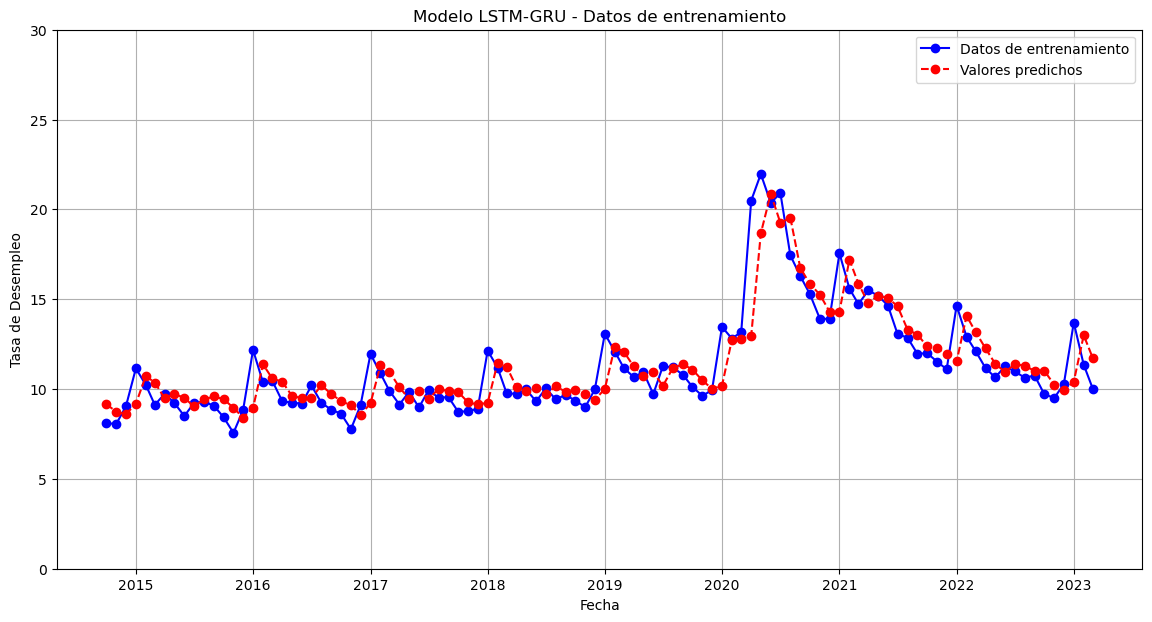

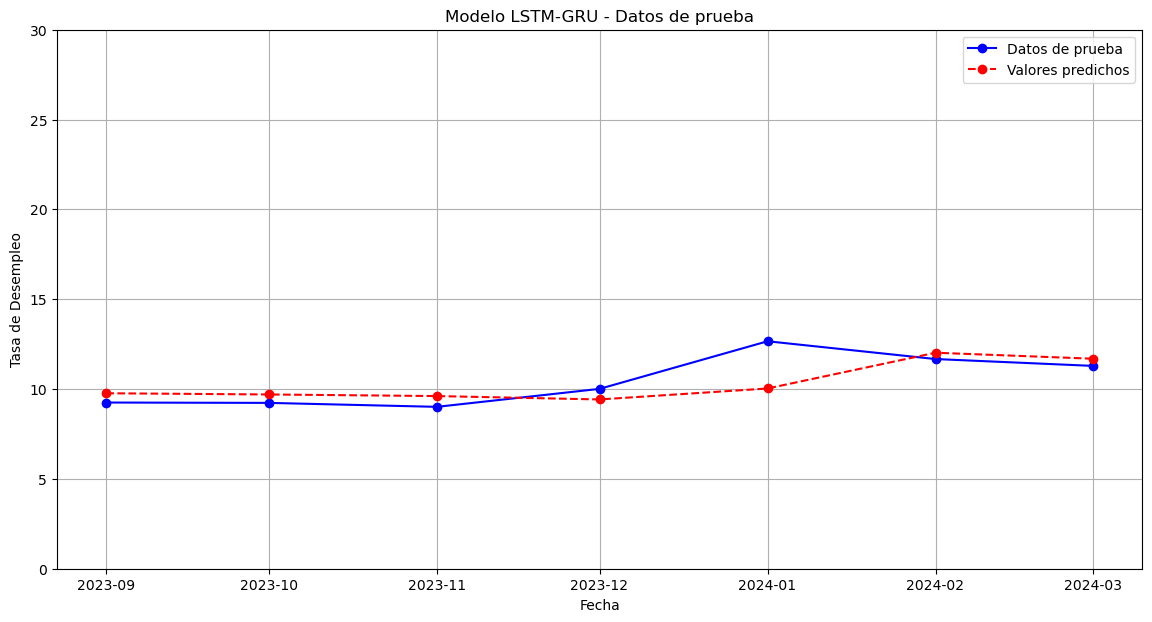

1/1 [==============================] - 0s 67ms/step


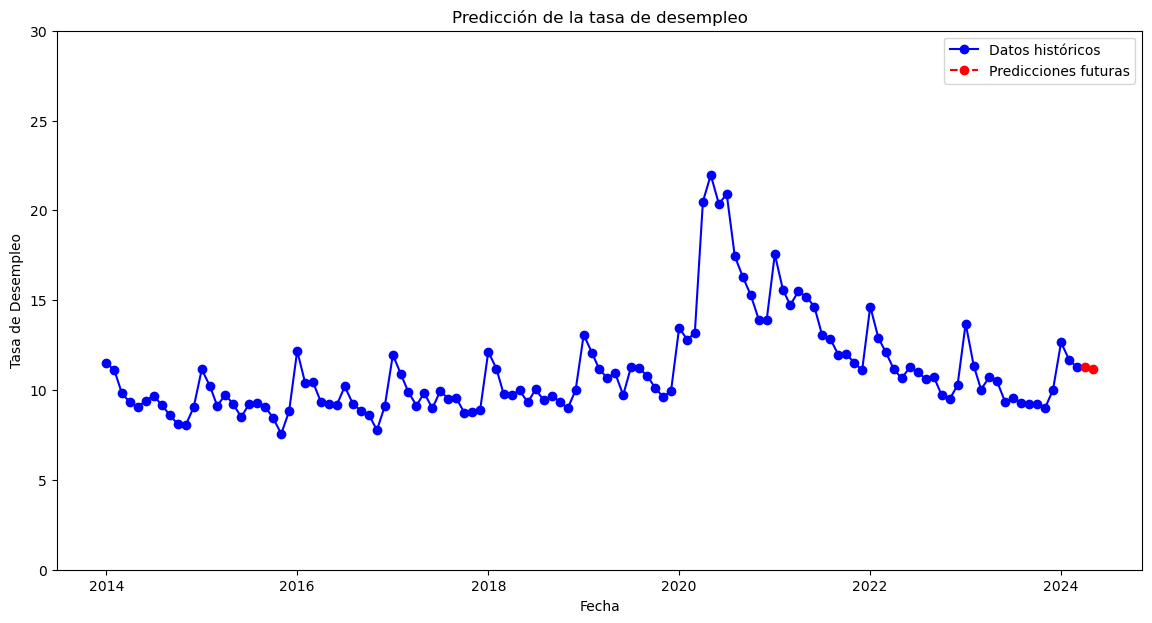

In [16]:
# Gráfico de datos de entrenamiento vs. predicciones
plt.figure(figsize=(14, 7))
train_dates = ts_unemployment.index[:train_size + window_size]
plt.plot(train_dates[window_size:], real_train_values[:len(train_dates[window_size:])], label='Datos de entrenamiento', marker='o', color='blue', linestyle='-')
plt.plot(train_dates[window_size:], train_predictions[:len(train_dates[window_size:])], label='Valores predichos', marker='o', color='red', linestyle='--')

plt.title('Modelo LSTM-GRU - Datos de entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.show()

# Crear gráfico de predicciones vs datos reales de prueba
plt.figure(figsize=(14, 7))
plt.plot(test_dates, real_test_values, label='Datos de prueba', marker='o', color='blue', linestyle='-')
plt.plot(test_dates, test_predictions, label='Valores predichos', marker='o', color='red', linestyle='--')

# Formatear gráfico
plt.title('Modelo LSTM-GRU - Datos de prueba')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.show()

# Predicción para los próximos 2 puntos
last_batch = data_scaled[-window_size:]
last_batch = np.expand_dims(last_batch, axis=0)

predicted_values = []
for _ in range(2):
    prediction = best_model.predict(last_batch)
    prediction = prediction.reshape(1, -1)
    predicted_value = scaler.inverse_transform(prediction)[0, 0]
    predicted_values.append(predicted_value)
    last_batch = np.append(last_batch[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)

# Crear gráfico de datos históricos y predicciones futuras
plt.figure(figsize=(14, 7))
plt.plot(ts_unemployment.index, ts_unemployment.values, label='Datos históricos', marker='o', color='blue', linestyle='-')
predicted_dates = [ts_unemployment.index[-1] + pd.DateOffset(months=i+1) for i in range(2)]
plt.plot(predicted_dates, predicted_values, label='Predicciones futuras', marker='o', color='red', linestyle='--')

# Formatear gráfico
plt.title('Predicción de la tasa de desempleo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Desempleo')
plt.ylim(0, 30)
plt.legend()

In [9]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 734)         2160896   
                                                                 
 gru (GRU)                   (None, 906)               4462956   
                                                                 
 dense (Dense)               (None, 1)                 907       
                                                                 
Total params: 6624759 (25.27 MB)
Trainable params: 6624759 (25.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


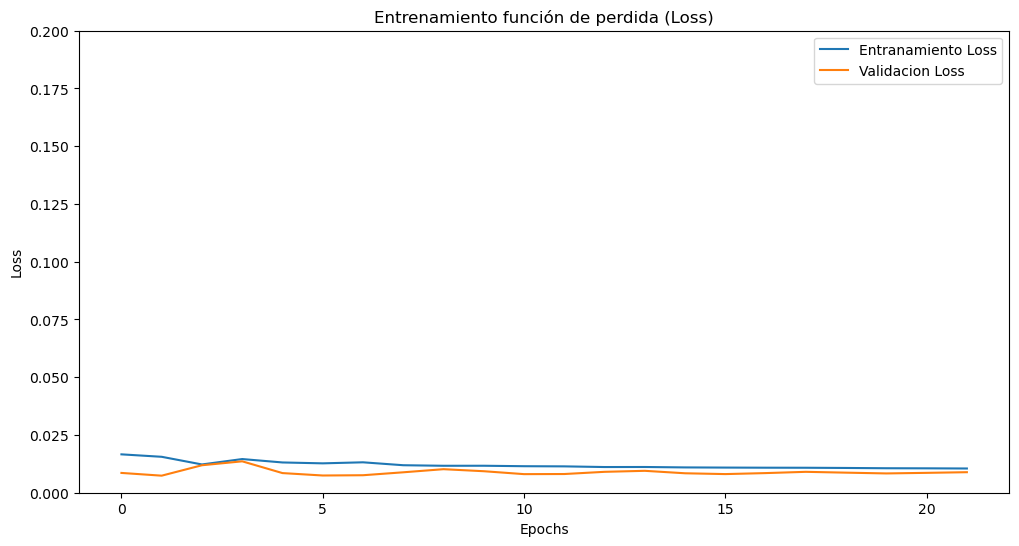

In [11]:
# Gráfico de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Entranamiento Loss')
plt.plot(history.history['val_loss'], label='Validacion Loss')
plt.ylim(0, 0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Entrenamiento función de perdida (Loss)')
plt.show()

In [12]:
# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Identificar la tasa de aprendizaje seleccionada
best_learning_rate = best_hps.get('learning_rate')
print(f"La mejor tasa de aprendizaje seleccionada es: {best_learning_rate}")


La mejor tasa de aprendizaje seleccionada es: 0.001
